<h2>Sentiment Analysis using Embeddings</h2>

Author:&emsp;Bruno Hunkeler<br> 
Date:&emsp;&emsp;xx.04.2018
<hr>

Sentiment analysis is a type of data mining that measures the inclination of people’s opinions through natural language processing (NLP), computational linguistics and text analysis, which are used to extract and analyze subjective information from the Web - mostly social media and similar sources. The analyzed data quantifies the general public's sentiments or reactions toward certain products, people or ideas and reveal the contextual polarity of the information.

Sentiment analysis is also known as opinion mining.

In the following we will analyse two indipendent situations. The first alalysis refers to IMDB moview review to predict if a review for a movie is positive or negative. The second analysis is based on Twitter data, where we identify if a message refers to a disaster or not.
We will use word embeddings in both situations. 

<b>Summary</b><br>
We received fairly decent results for both cases.<br>
IMDB moview review - about 76% accuracy<br>
Twitter Disaster   - about 94% accuracy<br>

<h2>Preliminaries</h2>

In [62]:
import keras
from keras.datasets import imdb
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print('Keras: {}'.format(keras.__version__))
print('TensorFlow: {}'.format(tf.VERSION))

Keras: 2.1.4
TensorFlow: 1.6.0


# Using word embeddings

---
Word vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the number of words in the vocabulary), while "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 token in this case). So, word embeddings pack more information into far fewer dimensions. 

We will use word embeddings, which were pre-computed solving a different machine learning problem then the one we are trying to solve. These are called "pre-trained word embeddings". 

<table>
  <tr>
    <th>Description of Ressource                     </th>
    <th>Ressource location                           </th>
  </tr>
  <tr>
    <td>IMDB moview review dataset                   </td>
    <td>http://ai.stanford.edu/~amaas/data/sentiment/</td>
  </tr>
  <tr>
    <td>Twitter disaster dataset</td>
    <td>unknown</td>
  </tr>
  <tr>
    <td>GloVe Embeddings</td>
    <td> https://nlp.stanford.edu/projects/glove/</td>
  </tr>
</table>


<h3>Datasets</h3>
The following resources have been used 

IMDB moview review dataset: http://ai.stanford.edu/~amaas/data/sentiment/<br>
Twitter disaster dataset:   unknown<br>
GloVe Embeddings:           https://nlp.stanford.edu/projects/glove/<br>

## Learning word embeddings with the `Embedding` layer


In [63]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

<h3>General Methods</h3><br> 
The following section contain methods, which are used in <b>Sentiment Analysis for disaster messages</b> as well as in <br> 
<b>IMDB movie reviews feedbacks</b>.

In [64]:
import os

def collectTextandLabelData(train_dir):
    '''
    prepare training data (text data and labels) located in the train_dir
    
    Param:  file path 
    return: texts, labels
    '''
    labels = []
    texts = []
    for label_type in ['neg', 'pos']:
        dir_name = train_dir + label_type
    
        for fname in os.listdir(dir_name):
            if fname[-4:] == '.txt':
                path = dir_name + '/' + fname
                f = open(path, encoding="utf8")
                texts.append(f.read())
                f.close()
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)
    
    return texts, labels

In [65]:
def tokenize(texts, max_words, maxlen):
    '''
    Vectorize the texts we collected. 
    
    Params: 
    texts      - raw text to vecorize
    max_words  - Only consider the top 10,000 words in the dataset
    maxlen     - Cut off the messages after 100 words
    
    return 
    data       - vectorized data 
    word_index - 
    sequences  - 
    
    '''
    tokenizer = Tokenizer(num_words = max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=maxlen)
    
    return data, word_index, sequences

In [66]:
# prepare sample size for train, validation and test sets
def proposeDataSplit(df):
    '''
    propose a data split:
    training data   - 80%, 
    validation data - 10%, 
    test data       - 10%
    
    Param:
    DataFrame: All available data as a dataframe.
    
    return: 
    training_samples, validation_samples, test_samples
    '''
    sample_size = df.shape[0]
    train_size = 0.8  # 80% of the data
    val_size   = 0.1  # ~10% of the data
    test_size  = 0.1  # ~10% of the data

    x_train = int(round(sample_size * train_size))
    x_val   = int((sample_size - x_train) / 2)
    x_test  = sample_size - (x_train + x_val)

    print('Sample_size:       {}'.format(sample_size))
    print('Training_samples:  {}'.format(x_train))
    print('Validation_sample: {}'.format(x_val))
    print('Test_samples:      {}'.format(x_test))
    
    return x_train, x_val, x_test

In [67]:
def someAnalytics(text, data):
    '''
    Prepare some analytics given by the data provided.
    
    Param:
    text - text data 
    data - 
    
    '''
    print('Texts[0]: ' + str(text))
    print('Texts[0] len : {}'.format(len(text)))
    print(' ')
    print('Data[0]: {}'.format(data))
    print('Data[0] len : {}'.format(len(data)))

In [68]:
def dataSplit(data, labels):
    '''
    split the data split into given fractions
    training data   - 80%, 
    validation data - 10%, 
    test data       - 10%
    
    Param:
    DataFrame: All available data as a dataframe.
    
    return: 
    x_train, y_train, x_val, y_val, x_test, y_test
    '''   
    training_samples, validation_samples, test_samples = proposeDataSplit(data)
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    x_train = data[:training_samples]
    y_train = labels[:training_samples]
    x_val = data[training_samples: training_samples + validation_samples]
    y_val = labels[training_samples: training_samples + validation_samples]
    x_test = data[training_samples + validation_samples: data.shape[0]]
    y_test = labels[training_samples + validation_samples: data.shape[0]]

    print('x_train: {}'.format(x_train.shape))
    print('y_train: {}'.format(y_train.shape))
    print('x_val:   {}'.format(x_val.shape))
    print('y_val:   {}'.format(y_val.shape))
    print('x_test:  {}'.format(x_test.shape))
    print('y_test:  {}'.format(y_test.shape))
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [69]:
def preprocessEmbeddings(filename):
    '''
    prepare the embeddings 
    
    Param:
    filename - location and file name of predefined embeddings file
    
    return:
    embeddings_index - indices of embeddings
    '''
    
    glove_dir = 'Data/6_1_glove.6B/'

    embeddings_index = {}
    path_name = glove_dir + filename # 'glove.6B.100d.txt'

    f = open(path_name, encoding="utf8") # , 'rb')  
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index
    

In [70]:
def embeddingsMatrix(word_index, embeddings_index, max_words, embedding_dim):
    '''
    Create the embeddings Matrix
    
    Params:
    word_index       - 
    embeddings_index - 
    max_words        - 
    embedding_dim    - 
    
    return:
    embedding Matrix
    '''
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if i < max_words:
            if embedding_vector is not None:
                # Words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [71]:
def plotAccuracy(history):
    
    '''
    plot training and validation accuracy as well as training and validation accuracy loss
    
    Param: 
    history  - history data from trained model 
    
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [72]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [73]:
def prepEmbeddings(dimension = 100):
    if dimension == 50:
        embeddings_index = preprocessEmbeddings('glove.6B.50d.txt')
    if dimension == 100:
        embeddings_index = preprocessEmbeddings('glove.6B.100d.txt')
    if dimension == 200:
        embeddings_index = preprocessEmbeddings('glove.6B.200d.txt')
    if dimension == 300:
        embeddings_index = preprocessEmbeddings('glove.6B.300d.txt')
        
    return embeddings_index, dimension

<h2>Sentiment Analysis on Movie Review Data</h2>

In [74]:
# Definitions 
maxlen        = 100              # Cut off the messages after 100 words
max_words     = 10000            # Only consider the top 10,000 words in the dataset
embedding_dim = 100

<h3>Download the IMDB data as raw text</h3>

First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset. Uncompress it. 
Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [75]:
texts, labels = collectTextandLabelData('data/6_1_aclImdb/train/')

<h3>Simple EDA</h3>
Perform a quick Data analysis of the given test & training data.

In [76]:
# create single Dataframe
df = pd.DataFrame(texts, columns=['text'])
df['label'] = pd.DataFrame(labels, columns=['label'])
df.head()

,text,label
0,Story of a man who has unnatural feelings for ...,0
1,Airport '77 starts as a brand new luxury 747 p...,0
2,This film lacked something I couldn't put my f...,0
3,"Sorry everyone,,, I know this is supposed to b...",0
4,When I was little my parents took me along to ...,0


In [77]:
print('Dataset Shape: {}'.format(df.shape) )
print("Categories:", np.unique(df['label']))

Dataset Shape: (25000, 2)
Categories: [0 1]


In [78]:
length = [len(i) for i in df['text']]
print("Mean Review length:", np.mean(length))
print("Standard Deviation:", round(np.std(length)))
print("Median Review length:", np.median(length))

Mean Review length: 1325.06964
Standard Deviation: 1003.0
Median Review length: 979.0


The distribution is pretty much right skewed.

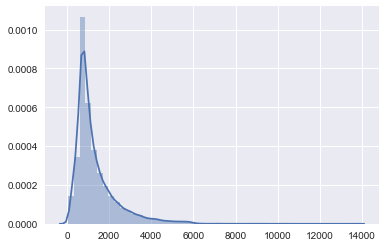

In [79]:
sns.set(); 
logLength = [math.log(i) for i in length]

ax = sns.distplot(length)
# ab = sns.distplot(logLength)

In [80]:
print("Number of unique words:", len(np.unique(np.hstack(texts))))

Number of unique words: 24904


We will place the data in a pandas data frame for further usage.

        text
label       
0      12500
1      12500


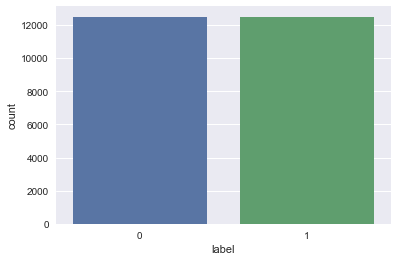

In [81]:
print(df.groupby("label").count())
sns.set(style="darkgrid")
ax = sns.countplot(x= 'label', data = df)

### Tokenize the data


Vectorize the texts we collected, and prepare a training and validation split. 
We will merely be using the concepts we introduced earlier in this section.

In [82]:
data, word_index, _ = tokenize(df['text'], max_words, maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [83]:
someAnalytics(df['text'][5], data[5])

Texts[0]: "It appears that many critics find the idea of a Woody Allen drama unpalatable." And for good reason: they are unbearably wooden and pretentious imitations of Bergman. And let's not kid ourselves: critics were mostly supportive of Allen's Bergman pretensions, Allen's whining accusations to the contrary notwithstanding. What I don't get is this: why was Allen generally applauded for his originality in imitating Bergman, but the contemporaneous Brian DePalma was excoriated for "ripping off" Hitchcock in his suspense/horror films? In Robin Wood's view, it's a strange form of cultural snobbery. I would have to agree with that.
Texts[0] len : 630
 
Data[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    9
  735   12  108 1415  166    1  323    4    3 2289 1598  450    2   15
   49  279   33   23 1637    2 1943    4 4990    2  900   21  550 3129
 1415   68  665 8775    4 5844 4990 5844 6702    5    1 3791 8776   48
   10   89   76    6   11  135   13 1598 1224

<h3>Data splitting</h3>
Split the data into a training, validation and test set. But first, shuffle the data, since we started from data
where samples might be ordered .

In [84]:
x_train, y_train, x_val, y_val, x_test, y_test = dataSplit(data, labels)

Sample_size:       25000
Training_samples:  20000
Validation_sample: 2500
Test_samples:      2500
x_train: (20000, 100)
y_train: (20000,)
x_val:   (2500, 100)
y_val:   (2500,)
x_test:  (2500, 100)
y_test:  (2500,)


<h3>Pre-process the embeddings</h3>
The following part prepares the Embedding data. We got the option for 50, 100, 200 and 300 dimensional embeddings.
You need to be aware that while choosing one of the embeddings (e.g. 300d) and potential input dimension of 500, we will right away start with 150'000 weights to learn.

In [85]:
embeddings_index, dimension = prepEmbeddings(dimension = 300)

Found 400000 word vectors.


In [86]:
df_embeddings_index = pd.DataFrame(embeddings_index)
df_embeddings_index.head()

,!,!!,!!!,!!!!,!!!!!,!?,!?!,"""",#,##,...,門下省,魏博,鳳翔,법정동,행정동,ﬁeld,ﬁgures,ﬁnds,ﬁrst,￥
0,0.237260,-0.12595,0.042297,-0.19203,-0.058498,-0.097111,0.36655,0.694700,0.068973,0.11268,...,0.420900,0.10068,0.452110,0.067855,0.38235,0.052934,-0.95989,0.279410,-0.080692,0.009333
1,-0.460510,-0.34353,-0.224780,-0.22459,-0.278360,-0.102980,-0.60528,0.221840,-0.078929,-0.18550,...,0.046505,-0.62194,-0.043153,-0.253830,-0.65987,0.355220,-0.99569,-0.216420,0.369590,-0.751300
2,0.075550,0.34653,-0.017088,0.31747,0.333860,0.029615,-0.19385,0.105260,0.562360,0.10455,...,0.522110,-0.32059,-0.381630,-0.213880,0.25891,-0.204220,-0.12623,-0.229840,-0.799810,-0.149240
3,-0.080934,-0.27601,0.649620,0.47202,0.115890,0.390530,0.13798,0.012382,0.446020,0.21052,...,0.605370,0.24434,-0.344230,0.434740,0.60343,-0.064635,0.79100,0.497870,0.402170,-0.086842
4,-0.580960,-0.43549,-0.310930,-0.35256,-0.068225,-0.614800,-0.22705,-0.255800,-0.734010,-0.45097,...,0.767770,0.71213,0.640150,-0.062237,0.54142,-0.254630,-0.53563,0.075809,0.158720,-0.523010


In [87]:
df_word_index = pd.DataFrame.from_dict(word_index, orient='index')

Now let's build an embedding matrix that we will be able to load into an Embedding layer. It must be a matrix of shape (max_words, 
embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in our reference word index (built during tokenization). Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.

In [88]:
embedding_dim = dimension
embedding_matrix = embeddingsMatrix(word_index, df_embeddings_index, max_words, embedding_dim)
df_embedding_matrix = pd.DataFrame(embedding_matrix)

<h3>Define a model</h3>
We will be using the same model architecture as before:

In [89]:
from keras import regularizers

def buildmodel(max_words, embedding_dim, maxlen):
    
    model = Sequential()
    # Input - Layer
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    
    # Hidden - Layers
    model.add(Dropout(0.3, noise_shape = None, seed = None))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2, noise_shape = None, seed = None))
    model.add(Dense(32, activation='relu'))
    
    # Output - Layer
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model 


# l1 Lasso
# L2 Ridge 
# l1l2(l1=0.01, l2=0.01) ElasticNET

In [90]:
model = buildmodel(max_words, embedding_dim, maxlen)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1920064   
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total para

In [91]:
# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [92]:
model.layers[0].set_weights([df_embedding_matrix])
model.layers[0].trainable = False

<h3>Train and evaluate</h3>

Let's compile our model and train it:

In [93]:
from mltools.modelUtils import modelUtils

util = modelUtils()
opt = util.optimizer('rmsprop', default = False)

initialized


In [94]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [95]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val)) # validation_split=0.2)
model.save_weights('model/weights/pre_trained_glove_model.h5')

Train on 20000 samples, validate on 2500 samples
Epoch 1/10
20000/20000 [==============================] - 8s 384us/step - loss: 0.6202 - acc: 0.6636 - val_loss: 0.5726 - val_acc: 0.7164
Epoch 2/10
20000/20000 [==============================] - 7s 373us/step - loss: 0.4827 - acc: 0.7668 - val_loss: 0.5658 - val_acc: 0.7012
Epoch 3/10
20000/20000 [==============================] - 8s 399us/step - loss: 0.4124 - acc: 0.8030 - val_loss: 0.5071 - val_acc: 0.7456
Epoch 4/10
20000/20000 [==============================] - 8s 391us/step - loss: 0.3521 - acc: 0.8366 - val_loss: 0.5322 - val_acc: 0.7436
Epoch 5/10
20000/20000 [==============================] - 8s 391us/step - loss: 0.3105 - acc: 0.8601 - val_loss: 0.5153 - val_acc: 0.7496
Epoch 6/10
20000/20000 [==============================] - 8s 395us/step - loss: 0.2725 - acc: 0.8798 - val_loss: 0.6379 - val_acc: 0.7400
Epoch 7/10
20000/20000 [==============================] - 8s 395us/step - loss: 0.2356 - acc: 0.8972 - val_loss: 0.6358 - v

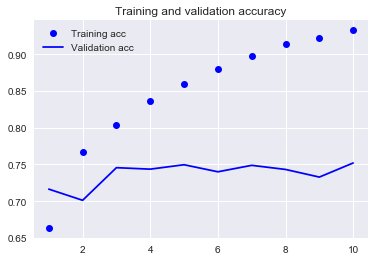

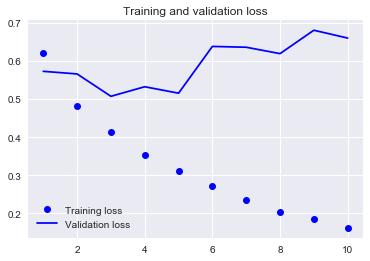

In [96]:
plotAccuracy(history)

In [97]:
model.load_weights('model/weights/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

2500/2500 [==============================] - 0s 110us/step


[0.6740867036819458, 0.758]

Using different Embeddings (50, 100, 200 or 300) dimensional will give us slightly different test accuracy.<br>
 50 dimensional -<br> 
100 dimensional -<br> 
200 dimensional - 70.9%<br> 
300 dimensional - 72.8% -> Regularized - 73.6%

In [98]:
y_pred = model.predict(x_test)

df_predicted = pd.DataFrame(y_pred)
df_predicted.columns = ['predicted']
df_predicted['ground truth'] = y_test
df_predicted['pred'] = np.where(df_predicted['predicted'] > 0.5, 1, 0)
df_predicted.head(8)


,predicted,ground truth,pred
0,0.674396,0,1
1,0.987118,1,1
2,0.997775,0,1
3,0.466231,1,0
4,0.101335,0,0
5,0.186136,1,0
6,0.131020,0,0
7,0.005472,0,0


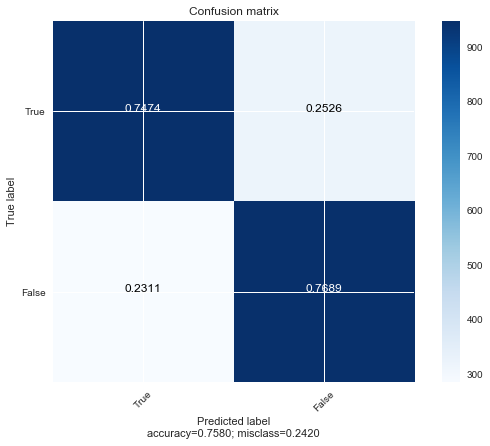

In [99]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, df_predicted['pred'])

plot_confusion_matrix(cm, 
                      target_names = ['True', 'False'],
                      title ='Confusion matrix',
                      cmap = None,
                      normalize=True)

<h2>Sentiment Analysis - Disasters on social media</h2>

We will try to correctly predict tweets that are about disasters. This is a very relevant problem, because:

- It is actionable to anybody trying to get signal from noise (such as police departments in this case)
- It is tricky because relying on keywords is harder than in most cases like spam

<b>Dataset:</b><br> 
Disasters on social media<br>
Contributors looked at over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”,<br> then noted whether the tweet referred to a disaster event.

<h3>Data prepration</h3>
Preprocess raw data retrieved from Twitter feeds.<br>
Make sure our tweets only have characters we want. We remove '#' characters but keep the words after the '#' sign, 
because they might be relevant (eg: #disaster)

In [100]:
# Load the raw social media Data into a Dataframe 
df_social_media_raw = pd.read_csv('Data/socialmedia_relevant_cols.csv')
df_social_media_raw.columns = ['text', 'choose_one', 'label']
df_social_media_raw.head()

,text,choose_one,label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [101]:
df_social_media_raw.describe()

,label
count,11771.000000
mean,0.426557
std,0.497339
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


The analysis of the dataset above shows that labes with a value 2 exist in a dataset. We need to analyse this part 
a little closer 

In [102]:
unDecided = df_social_media_raw[df_social_media_raw['label'] == 2]

print('Unclear Cases: {}'.format(unDecided.shape[0]))

# Eval percentage of 
print('% of all data: {}'.format(round(unDecided.shape[0] / df_social_media_raw.shape[0], 4)))
print()
print('Cases: {}'.format(unDecided))

Unclear Cases: 16
% of all data: 0.0014

Cases:                                                     text    choose_one  label
279      Why is there an ambulance right outside my work  Can't Decide      2
1628                     @MisfitRarity misfit got bombed  Can't Decide      2
1763   @RockBottomRadFM Is one of the challenges on T...  Can't Decide      2
1964   ? High Skies - Burning Buildings ? http://t.co...  Can't Decide      2
1970   What if we used drones to help firefighters le...  Can't Decide      2
2524   San Bernardino I10 W Eo / Redlands Blvd **Trfc...  Can't Decide      2
2592   Kinetic Typography Crash Course (After Effects...  Can't Decide      2
3068                     Deaths 5 http://t.co/0RtxTT11jj  Can't Decide      2
3807   @MythGriy they can't detonate unless they touc...  Can't Decide      2
3963   MPD director Armstrong: when this first happen...  Can't Decide      2
4083   Displaced Persons GN (2014 Image) #1-1ST NM ht...  Can't Decide      2
4135   Large rai

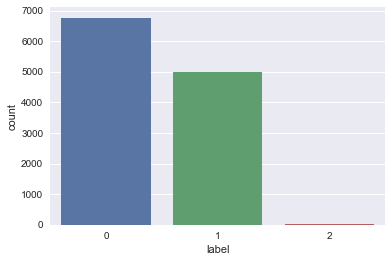

In [103]:
ax = sns.countplot(x= 'label', data = df_social_media_raw)

We have some items which are unclear. Therefore we will ignor them since this is such a minor fraction.

In [104]:
# Drop rows which are not clear. This is ok since we only have 16 rows compred to 11771 data items
df_social_media_raw = df_social_media_raw[df_social_media_raw['label'] != 2]
df_social_media_raw.describe()

,label
count,11755.000000
mean,0.424415
std,0.494275
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


<b>Data Overview</b><br>
Check the how balanced out training data is.

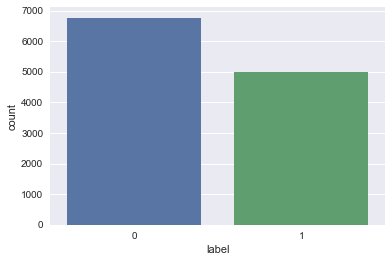

In [105]:
df_social_media_raw.groupby("label").count()
ax = sns.countplot(x= 'label', data = df_social_media_raw)

In [106]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [107]:
df_social_media = standardize_text(df_social_media_raw, "text")

# remove unused columns 
df_social_media = df_social_media.drop(['choose_one'], axis=1)
df_social_media.to_csv("data/social_media_clean_data.csv")
df_social_media.head()

,text,label
0,just happened a terrible car crash,1
1,our deeds are the reason of this earthquake m...,1
2,"heard about earthquake is different cities, s...",1
3,"there is a forest fire at spot pond, geese are...",1
4,forest fire near la ronge sask canada,1


<h3>Load the cleaned data</h3>
We will now use the clean data for predicting positive(disaster) / negative(non disaster) messages 

In [108]:
def loadSocialMediaData(name):
    if name == 'social_media_clean_data.csv':
        # Load the cleaned Twitter Data into a Dataframe 
        path = 'data/' + name
        df = pd.read_csv(path)

        # remove unused columns 
        df = df.drop(['Unnamed: 0'], axis=1)
    if name == 'clean_data.csv': 
        # Load the cleaned Twitter Data into a Dataframe 
        path = 'data/' + name
        df = pd.read_csv(path)

        # remove unused columns 
        df = df.drop(['Unnamed: 0', 'choose_one'], axis=1)

    print('Shape: {} '.format(df.shape))
        
    # change column names 
    df.columns = ['text', 'label']
    
    return df

In [109]:
# df = loadSocialMediaData('social_media_clean_data.csv')
df = loadSocialMediaData('clean_data.csv')

# Drop rows which are not clear. This is ok since we only have 16 rows compred to 11771 data items
df = df[df['label'] != 2]

df.head()

Shape: (11771, 2) 


,text,label
0,just happened a terrible car crash,1
1,our deeds are the reason of this earthquake m...,1
2,"heard about earthquake is different cities, s...",1
3,"there is a forest fire at spot pond, geese are...",1
4,forest fire near la ronge sask canada,1


In [110]:
df = loadSocialMediaData('clean_data.csv')
df = df[df['label'] != 2]
print('Shape post cleaning: {}'.format(df.shape))

Shape: (11771, 2) 
Shape post cleaning: (11755, 2)


<h2>Using pre-trained word embeddings</h2>



In [111]:
maxlen = 100                 # Cut off the messages after 100 words
max_words = 10000            # Only consider the top 10,000 words in the dataset

training_samples, validation_samples, test_samples = proposeDataSplit(df)

Sample_size:       11755
Training_samples:  9404
Validation_sample: 1175
Test_samples:      1176


In [112]:
# tokenize twitter messages 

data, word_index, _ = tokenize(df['text'], max_words, maxlen)
labels = np.asarray(df['label'])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 19082 unique tokens.
Shape of data tensor: (11755, 100)
Shape of label tensor: (11755,)


In [113]:
 someAnalytics(df['text'][5], data[5])

Texts[0]: all residents asked to 'shelter in place' are being notified by officers  no other evacuation or shelter in place orders are expected
Texts[0] len : 133
 
Data[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   36 1447 1591    4 9163    3
 6052   19  138 9164   16 1909   35  298  320   53 2395    3  745 1801
   19 1320]
Data[0] len : 100


<h3>Data splitting</h3>
Split the data into a training, validation and test set. But first, shuffle the data, since we started from data
where samples might be ordered .

In [114]:
x_train, y_train, x_val, y_val, x_test, y_test = dataSplit(data, labels)

Sample_size:       11755
Training_samples:  9404
Validation_sample: 1175
Test_samples:      1176
x_train: (9404, 100)
y_train: (9404,)
x_val:   (1175, 100)
y_val:   (1175,)
x_test:  (1176, 100)
y_test:  (1176,)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

<h3>Pre-process the embeddings</h3>

Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [115]:
# set to True if you need to run this part individually

individual = False
if individual:
    embeddings_index, dimension = prepEmbeddings(dimension = 300)
    
    # create dataframe
    df_embeddings_index = pd.DataFrame(embeddings_index)
    df_embeddings_index.head()
    
    df_word_index = pd.DataFrame.from_dict(word_index, orient='index')
    
    embedding_dim = dimension
    embedding_matrix = embeddingsMatrix(word_index, df_embeddings_index, max_words, embedding_dim)
    
    df_embedding_matrix = pd.DataFrame(embedding_matrix)
    print('Dimensions: ' + str((df_embedding_matrix).shape))


In [116]:
# df_embeddings_index = pd.DataFrame(embeddings_index)
# df_embeddings_index.head()

In [117]:
# df_word_index = pd.DataFrame.from_dict(word_index, orient='index')


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [118]:
# embedding_dim = 100
# embedding_matrix = embeddingsMatrix(word_index, df_embeddings_index, max_words, embedding_dim)

In [119]:
# df_embedding_matrix = pd.DataFrame(embedding_matrix)
# print('Dimensions: ' + str((df_embedding_matrix).shape))

### Define a model

We will be using the same model architecture as before:

In [120]:
def buildmodel(max_words, embedding_dim, maxlen):
    
    model = Sequential()
    
    # Input - Layer
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    
    # Hidden - Layers
    model.add(Flatten())
    model.add(Dropout(0.3, noise_shape = None, seed = None))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2, noise_shape = None, seed = None))
    model.add(Dense(32, activation='relu'))
    
    # Output - Layer
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model 

In [121]:
max_words = 10000
embedding_dim = dimension
maxlen = 100
model = buildmodel(max_words, embedding_dim, maxlen)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1920064   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total para

In [122]:
# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [123]:
model.layers[0].set_weights([df_embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

<h3>Train and evaluate</h3>
Let's compile our model and train it:

In [124]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [125]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val)) # validation_split=0.2)
model.save_weights('model/weights/twitter_pre_trained_glove_model.h5')

Train on 9404 samples, validate on 1175 samples
Epoch 1/10
9404/9404 [==============================] - 4s 439us/step - loss: 0.6354 - acc: 0.6341 - val_loss: 0.5949 - val_acc: 0.6706
Epoch 2/10
9404/9404 [==============================] - 4s 405us/step - loss: 0.5163 - acc: 0.7393 - val_loss: 0.5858 - val_acc: 0.6953
Epoch 3/10
9404/9404 [==============================] - 4s 403us/step - loss: 0.4246 - acc: 0.8080 - val_loss: 0.5729 - val_acc: 0.7234
Epoch 4/10
9404/9404 [==============================] - 4s 399us/step - loss: 0.3377 - acc: 0.8507 - val_loss: 0.6415 - val_acc: 0.7030
Epoch 5/10
9404/9404 [==============================] - 4s 397us/step - loss: 0.2804 - acc: 0.8849 - val_loss: 0.7145 - val_acc: 0.7174
Epoch 6/10
9404/9404 [==============================] - 4s 415us/step - loss: 0.2317 - acc: 0.9094 - val_loss: 0.7635 - val_acc: 0.7030
Epoch 7/10
9404/9404 [==============================] - 4s 406us/step - loss: 0.2081 - acc: 0.9189 - val_loss: 0.8519 - val_acc: 0.6936


Let's plot its performance over time:

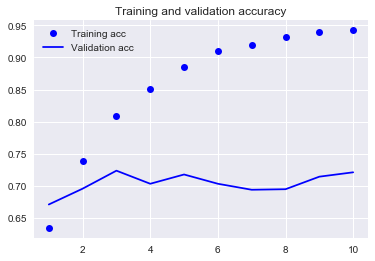

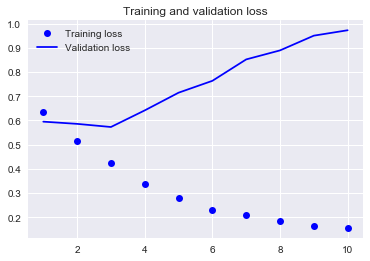

In [126]:
plotAccuracy(history)

In [127]:
model.load_weights('model/weights/twitter_pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

1176/1176 [==============================] - 0s 108us/step


[1.0835029705852068, 0.6794217687074829]

Using different Embeddings (50, 100, 200 or 300) dimensional will give us slightly different test accuracy.<br>
 50 dimensional -<br> 
100 dimensional -<br>
200 dimensional - 00.0%<br>
300 dimensional - 77.6%

In [128]:
y_pred = model.predict(x_test)

df_predicted = pd.DataFrame(y_pred)
df_predicted.columns = ['predicted']
df_predicted['ground truth'] = y_test
df_predicted['pred'] = np.where(df_predicted['predicted'] > 0.5, 1, 0)
df_predicted.head(8)

,predicted,ground truth,pred
0,0.566320,1,1
1,0.971488,1,1
2,0.000001,0,0
3,0.000015,0,0
4,0.005642,0,0
5,0.006483,0,0
6,0.270392,1,0
7,0.003257,0,0


[[543 165]
 [212 256]]


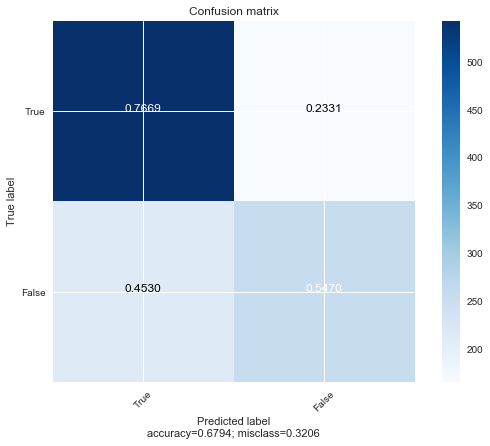

In [129]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, df_predicted['pred'])
print(cm)
plot_confusion_matrix(cm, 
                      target_names = ['True', 'False'],
                      title ='Confusion matrix',
                      cmap = None,
                      normalize=True)


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [130]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = buildmodel(max_words, embedding_dim, maxlen)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1920064   
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total para

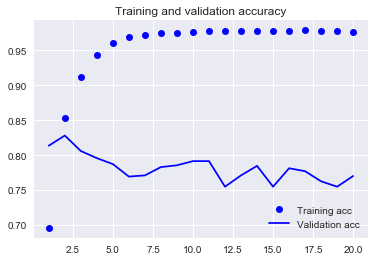

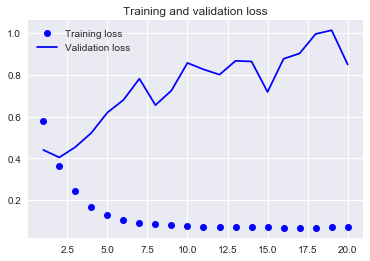

In [131]:
plotAccuracy(history)

We see here a clear overfittig of the model, but still the validation accuracy is in the region of about 80. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you increase the number of training samples, the perfromance will certainly improve. One more aspect would be regularization. Dropout or L2-Regularization should be condidered. 

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [132]:
# texts, labels = collectTextandLabelData('Data/6_1_aclImdb/test/')

In [133]:
_, _, sequences = tokenize(df['text'], max_words, maxlen)

x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Found 19082 unique tokens.


And let's load and evaluate the first model:

In [134]:
model.load_weights('model/weights/twitter_pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

11755/11755 [==============================] - 1s 127us/step


[0.25230430938190174, 0.9250531688643131]

Using different Embeddings (50, 100, 200 or 300) dimensional will give us slightly different test accuracy.<br>
 50 dimensional -<br> 
100 dimensional -<br>
200 dimensional - 94.8%<br>
300 dimensional - 94.3%

In [135]:
y_pred = model.predict(x_test)

df_predicted = pd.DataFrame(y_pred)
df_predicted.columns = ['predicted']
df_predicted['ground truth'] = y_test
df_predicted['pred'] = np.where(df_predicted['predicted'] > 0.5, 1, 0)
df_predicted.head(8)

,predicted,ground truth,pred
0,0.985228,1,1
1,0.995761,1,1
2,0.964051,1,1
3,0.999278,1,1
4,0.997695,1,1
5,1.000000,1,1
6,0.998834,1,1
7,0.985179,1,1


[[6419  347]
 [ 534 4455]]


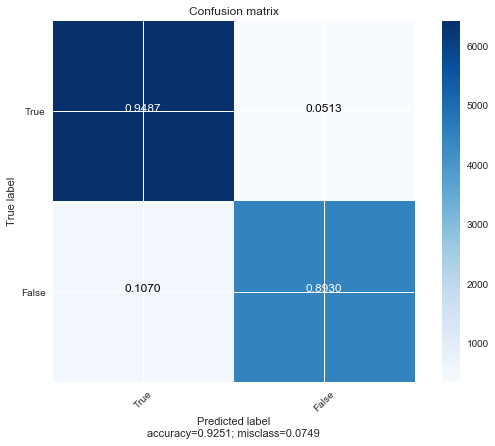

In [136]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, df_predicted['pred'])
print(cm)
plot_confusion_matrix(cm, 
                      target_names = ['True', 'False'],
                      title ='Confusion matrix',
                      cmap = None,
                      normalize=True)

<h3>References:</h3>

<b>GloVe</b><br>
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.<br>
<br>
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]
